In [1]:
#Jupyter notebook to check if imports work correctly
%matplotlib inline
import sys
sys.path.append('./src')
import HubbardEvolutionChain as hc
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import random as rand
import scipy.linalg as la

provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True


/home/kaelyn/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-03-25 11:08:44,792: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
#==========Set Parameters of the System=============#
dt = 0.5 #Delta t
T = 5.
time_steps = int(T/dt)
t = 1.0  #Hopping parameter
U = 2.  #On-Site repulsion
#time_steps = 10
nsites = 3
trotter_slices = 10
initial_state = np.array([1, 4])

#Run simulation
run_results = hc.sys_evolve(nsites, initial_state, T, dt, t, U, trotter_slices)
#print(True if np.isscalar(initial_state) else False)

Num Steps:  10
Total Time:  5.0
Job Status: job has successfully run
{'010010': 8192}
Job:  1  of  10  complete.
Job Status: job has successfully run
{'010001': 939, '010010': 3195, '010100': 865, '100001': 331, '100010': 880, '100100': 330, '001001': 353, '001010': 939, '001100': 360}
Job:  2  of  10  complete.
Job Status: job has successfully run
{'010001': 90, '010010': 1452, '010100': 80, '100001': 1504, '100010': 86, '100100': 1457, '001001': 1871, '001010': 88, '001100': 1564}
Job:  3  of  10  complete.
Job Status: job has successfully run
{'010001': 857, '010010': 36, '010100': 660, '100001': 524, '100010': 583, '100100': 1946, '001001': 2188, '001010': 858, '001100': 540}
Job:  4  of  10  complete.
Job Status: job has successfully run
{'010001': 104, '010010': 1105, '010100': 5, '100001': 159, '100010': 2, '100100': 3049, '001001': 3513, '001010': 100, '001100': 155}
Job:  5  of  10  complete.
Job Status: job has successfully run
{'010001': 741, '010010': 296, '010100': 1269, '

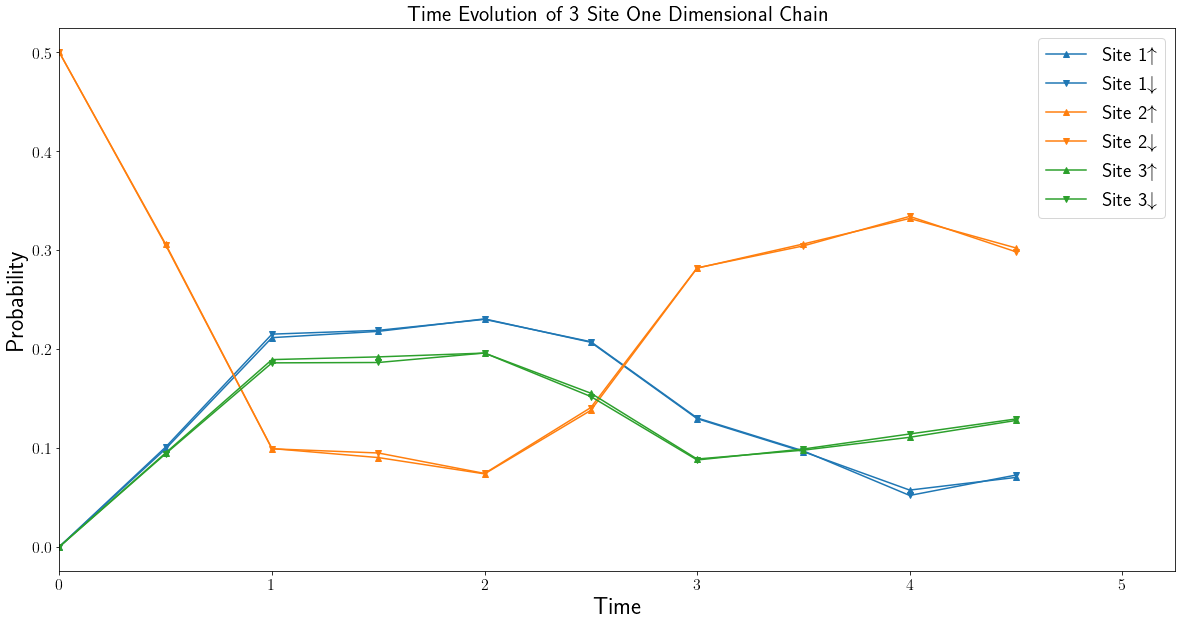

In [7]:

#Process and plot data
'''The procedure here is, for each fermionic mode, add the probability of every state containing
that mode (at a given time step), and renormalize the data based on the total occupation of each mode.
Afterwards, plot the data as a function of time step for each mode.'''
proc_data = np.zeros((2*nsites, time_steps))
timesq = np.arange(0.,time_steps*dt, dt)

#Sum over time steps
for t in range(time_steps):
    #Sum over all possible states of computer
    for i in range(2**(2*nsites)):
        #num = get_bin(i, 2*nsite)
        num = ''.join( list( reversed(hc.get_bin(i,2*nsites)) ) )
        #For each state, check which mode(s) it contains and add them
        for mode in range(len(num)):
            if num[mode]=='1':
                proc_data[mode,t] += run_results[i,t]
    
    #Renormalize these sums so that the total occupation of the modes is 1
    norm = 0.0
    for mode in range(len(num)):
        norm += proc_data[mode,t]
    proc_data[:,t] = proc_data[:,t] / norm
    
'''
At this point, proc_data is a 2d array containing the occupation 
of each mode, for every time step
'''
    
#Create plots of the processed data
fig2, ax2 = plt.subplots(figsize=(20,10))
colors = list(mcolors.TABLEAU_COLORS.keys())

for i in range(nsites):
    #Create string label
    strup = "Site "+str(i+1)+r'$\uparrow$'
    strdwn = "Site "+str(i+1)+r'$\downarrow$'
    ax2.plot(timesq, proc_data[i,:], marker="^", color=str(colors[i]), label=strup)
    ax2.plot(timesq, proc_data[i+nsites,:], marker="v", color=str(colors[i]), label=strdwn)


#ax2.set_ylim(0, 0.55)
ax2.set_xlim(0, time_steps*dt+dt/2.)
#ax2.set_xticks(np.arange(0,time_steps*dt+dt, 0.2))
#ax2.set_yticks(np.arange(0,0.55, 0.05))
ax2.tick_params(labelsize=16)
ax2.set_title('Time Evolution of 3 Site One Dimensional Chain', fontsize=22)
ax2.set_xlabel('Time', fontsize=24)
ax2.set_ylabel('Probability', fontsize=24)
ax2.legend(fontsize=20)
